In [153]:
%%html
<h1 style="text-align: center; font-size: 8rem">Act-II</h1>
<h2>Steps:</h2>
<ol>
    <li>Feature engineering</li>
    <li>Hyperparameter tuning</li>
    <li>Feature selection(feature importances, shap)</li>
    <li>More hyperparameter tuning and building final model</li>
    <li>submit & check the score</li>
</ol>

In [154]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports & Config

In [155]:
from utils import *

In [156]:
dataset_path, result_path = get_paths()
config_output()
list_files(dataset_path)

setting no. of rows displayed: 1000
setting no. of columns displayed: 1000
setting warnings to be ignored.


['data_description.txt', 'train.csv', '.ipynb_checkpoints', 'test_ftrs_added.csv', 'train_with_folds.csv', 'test.csv', 'sample_submission.csv', 'test_with_folds.csv', 'train_ftrs_added.csv']


In [157]:
train_df = pd.read_csv(dataset_path / "train_with_folds.csv")
test_df = pd.read_csv(dataset_path / "test_with_folds.csv")
sample_subm_df = pd.read_csv(dataset_path / "sample_submission.csv")

print(train_df.shape, test_df.shape)

(1460, 82) (1459, 80)


## Feature engineering

### Target skewness correction

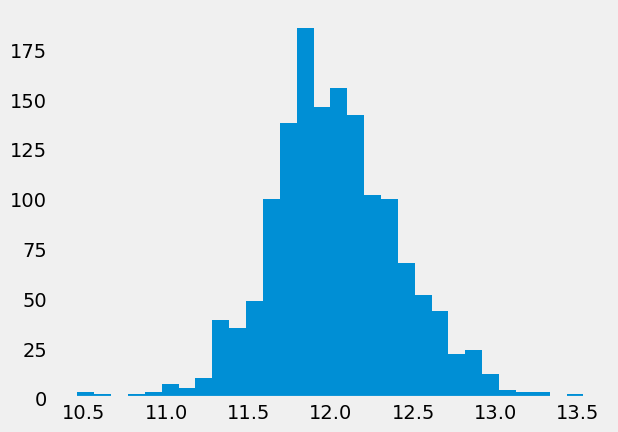

In [158]:
train_df["log_SalePrice"] = train_df.SalePrice.apply(np.log1p)
train_df.log_SalePrice.hist(bins=30)
plt.grid(False)
plt.show()

### Identifying different type of columns

In [159]:
useful_cols = [col for col in train_df.columns if col not in ["SalePrice", "log_SalePrice", "Id", "fold"]]
len(useful_cols)

79

In [160]:
ordinal_cols = [
    "MSSubClass",
    "LotShape",
    "LandSlope",
    "OverallQual",
    "OverallCond",
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "HeatingQC",
    "KitchenQual",
    "Functional",
    "FireplaceQu",
    "GarageQual",
    "GarageFinish",
    "GarageCond",
    "PoolQC",
    "Fence",
]

num_cols = [
    "LotFrontage",
    "LotArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    # can they be ordinal columns
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    #
    "BedroomAbvGr",
    "KitchenAbvGr",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "MasVnrArea",
]

cat_cols = [
    "MSZoning",
    "Street",
    "Alley",
    "LandContour",  # can it be an ordinal variable
    "Utilities",
    "LotConfig",
    "Neighborhood",
    "Condition1",
    "Condition2",
    "BldgType",
    "HouseStyle",
    "RoofStyle",
    "RoofMatl",
    "Exterior1st",
    "Exterior2nd",
    "MasVnrType",
    "Foundation",
    "Heating",
    "CentralAir",
    "Electrical",
    "GarageType",
    "PavedDrive",
    "MiscFeature",
    "MoSold",
    "SaleType",
    "SaleCondition",
]

year_cols = [
    "GarageYrBlt",
    "YearBuilt",
    "YrSold",
    "YearRemodAdd",
]


### Fill nulls

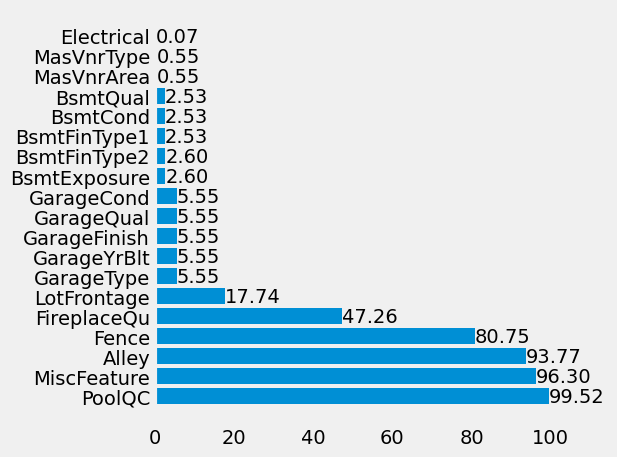

In [161]:
train_na_df = (
    train_df.isnull()
    .sum()
    .where(lambda x: x > 0)
    .dropna()
    .sort_values(ascending=False)
    .reset_index()
)
train_na_df.columns = ["col_name", "value"]
train_na_df["pct"] = train_na_df.value * 100 / len(train_df)

plt.barh(y=train_na_df.col_name, width=train_na_df.pct)
for ix, row in train_na_df.iterrows():
    plt.text(row["pct"], ix - 0.3, f'{row["pct"]:.2f}')

plt.grid(False)
plt.margins(x=0.15)
plt.tight_layout()
plt.show()

In [162]:
# remove features with null percentage > 40

null_cols = train_na_df[train_na_df.pct > 40].col_name.tolist()
print(null_cols)
useful_cols = [col for col in useful_cols if col not in null_cols]

ordinal_cols = list(set(ordinal_cols).intersection(useful_cols))
cat_cols = list(set(cat_cols).intersection(useful_cols))
num_cols = list(set(num_cols).intersection(useful_cols))
year_cols = list(set(year_cols).intersection(useful_cols))

try:
    train_df.drop(null_cols, axis=1, inplace=True)
    test_df.drop(null_cols, axis=1, inplace=True)
except:
    pass

train_df.shape, test_df.shape

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']


((1460, 78), (1459, 75))

> **Observations**

1. PoolQC, MiscFeature, Alley, Fence - we can fill these values based on data_description given, assuming that null value mean pool/alley/fence not present in the given house.
2. Null values in GarageType, GarageFinish, GarageYrBlt, GarageQual, GarageCond could be becuase of "No Garage" in the house. We can fill "NA" in those columns.
3. Same with with basement columns; BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual, BsmtCond

In [163]:
na_fill_values = {
    "PoolQC": "NA",
    "MiscFeature": "NA",
    "Alley": "NA",
    "Fence": "NA",
    "BsmtExposure": "NA",
    "BsmtFinType2": "NA",
    "BsmtFinType1": "NA",
    "BsmtQual": "NA",
    "BsmtCond": "NA",
    "GarageType": "NA",
    "GarageFinish": "NA",
    "GarageQual": "NA",
    "GarageCond": "NA",
    "FireplaceQu": "NA",
}

In [164]:
# merge train and test for filling null values
train_test_df = pd.concat([train_df[useful_cols], test_df[useful_cols]])
train_test_df.shape

(2919, 74)

lets drop GarageYrBlt - why?
1. It's a non-measurable column
1. wherever it is null, it means garage is not present in the house

So, let's create a new feature whether there is a garage in the house

In [165]:
train_test_df["GaragePresent"] = ~train_test_df["GarageYrBlt"].isnull()
try:
    train_test_df.drop("GarageYrBlt", axis=1, inplace=True)
    year_cols.remove("GarageYrBlt")
except:
    pass

In [166]:
# fill the nulls
train_test_df.fillna(value=na_fill_values, inplace=True)

In [167]:
for col, nulls in train_test_na_sum.items():
    if col in cat_cols or col in ordinal_cols:
        most_freq_val = train_test_df[col].mode().values[0]
        train_test_df[col].fillna(most_freq_val, inplace=True)
    elif col in num_cols:
        knn = KNNImputer()
        train_test_df.loc[:, num_cols] = knn.fit_transform(train_test_df[num_cols])

### Creating new features

In [174]:
def add_features_to_df(df):
    df["SqFtPerRoom"] = df["GrLivArea"] / (df["TotRmsAbvGrd"] +
                                           df["FullBath"] +
                                           df["HalfBath"] +
                                           df["KitchenAbvGr"])
    df["TotalHomeQual"] = df["OverallQual"] + df["OverallCond"]
    df["TotalBathrooms"] = df["FullBath"] + 0.5 * df["HalfBath"] + df["BsmtFullBath"] + 0.5 * df["BsmtHalfBath"]
    df["HighQualSF"] = df["1stFlrSF"] + df["2ndFlrSF"]
    # YearRemodAdd - convert to bool value to represent whether house is renovated or not
    df["IsRenovated"] = ~(df["YearBuilt"] == df["YearRemodAdd"])
    df["Age"] = df["YrSold"] - df["YearBuilt"]
    
add_features_to_df(train_test_df)

# add new columns to useful cols
useful_cols += ["SqFtPerRoom", "TotalHomeQual", "TotalBathrooms", "HighQualSF"]
num_cols += ["SqFtPerRoom", "TotalHomeQual", "TotalBathrooms", "HighQualSF", "Age"]
cat_cols += ["IsRenovated"]

cols_to_drop = ["YearRemodAdd"]
try:
    train_test_df.drop(cols_to_drop, axis=1, inplace=True)
except:
    pass

In [196]:
# split train_test_df to train & test
pd.merge(train_df, train_test_df, how="inner", on="Id")

KeyError: 'Id'

### Ordinal category ordering
* Ordinal columns have certain ordering to the values it has.<br>
* For example, LotShape has four values which can be ordered mathematically Irregular(IR3) < Moderately Irregular(IR2) < Slightly Irregular(IR1) < Regular(Reg)<br>
* We can pass the ordering while applying ordinal transformation

In [168]:
ordinal_cols_order = {
    "MSSubClass": [20, 30, 40, 45, 50, 60, 70, 75, 80, 85, 90, 120, 150, 160, 180, 190],
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Gtl", "Mod", "Sev"],
    "ExterQual": ["Ex", "Gd", "TA", "Fa", "Po"],
    "ExterCond": ["Ex", "Gd", "TA", "Fa", "Po"],
    "HeatingQC": ["Ex", "Gd", "TA", "Fa", "Po"],
    "KitchenQual": ["Ex", "Gd", "TA", "Fa", "Po"],
    "Functional": ["Typ", "Min1", "Min2", "Maj1", "Maj2", "Sev", "Sal"],
    # "FireplaceQu": ["Ex", "Gd", "TA", "Fa", "Po", "NA"],
    "GarageFinish": ["Fin", "RFn", "Unf", "NA"],
    "GarageCond": ["Ex", "Gd", "TA", "Fa", "Po", "NA"],
    "GarageQual": ["Ex", "Gd", "TA", "Fa", "Po", "NA"],
    "BsmtExposure": ["Gd", "Av", "Mn", "No", "NA"],
    "BsmtFinType2": ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "NA"],
    "BsmtFinType1": ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "NA"],
    "BsmtCond": ["Ex", "Gd", "TA", "Fa", "Po", "NA"],
    "BsmtQual": ["Ex", "Gd", "TA", "Fa", "Po", "NA"],
    # "PoolQC": ["Ex", "Gd", "TA", "Fa", "NA"],
    # "Fence": ["GdPrv", "MnPrv", "GdWo", "MnWw", "NA"],
}

In [169]:
# transform the train and test ordinal columns
ot = OrdinalTransformer()
train_test_df.loc[:, ordinal_cols] = ot.fit_transform(train_test_df[ordinal_cols])

In [191]:
ohe = OneHotEncoder(sparse=False, drop="if_binary")
ohe.fit_transform(train_test_df[cat_cols])


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [193]:
ohe.get_feature_names_out()

array(['Street_Pave', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NPkVill',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_SWISU', 'Neighborhood_Sawyer',
       'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber',
       'Neighborhood_Veenker', 'Exterior1st_AsbShng',
       'Exterior1st_AsphShn', 'Exterior1st_BrkComm',
       'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd',
       'Exterior1st_HdBoard', 'Exterior1st_ImStucc',
       'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone',
       'Exterior1st_Stucc

In [183]:
# convert categorical variables to dummies
train_test_df = pd.get_dummies(train_test_df, columns=cat_cols, drop_first=True)

AttributeError: 'DataFrame' object has no attribute 'IsRenovated'

In [129]:
train_df.to_csv(dataset_path / "train_ftrs_added.csv", index=False)
test_df.to_csv(dataset_path / "test_ftrs_added.csv", index=False)

### Preprocessing pipeline

In [124]:
def get_preprocessing_pipe(ordinal_cols=None, cat_cols=None, year_cols=None, num_cols=None):
        preprocess_pipeline = Pipeline([
                ("fill_na", FillNulls()),
                ("cols_transformer", ColumnTransformer([
                        ("ord_pipe", Pipeline([
                                        # ("select_cols", ColumnSelector(ordinal_cols)),
                                        ("inorder", OrdinalTransformer()),
                                ]), ordinal_cols),
                        ("cat_pipe", Pipeline([
                                        # ("select_cols", ColumnSelector(cat_cols)),
                                        ("dummies", OneHotEncoder(handle_unknown="ignore")),
                                ]), cat_cols),
                        ("year_pipe", Pipeline([
                                        # ("select_cols", ColumnSelector(year_cols)),
                                        ("calc_age", TransformDate()),
                                        ("scale", RobustScaler()),
                                ]), year_cols),
                        ("num_pipe", Pipeline([
                                        # ("select_cols", ColumnSelector(num_cols)),
                                        ("scale", RobustScaler()),
                                ]), num_cols),
                        ])
                )]
        )
        return preprocess_pipeline

In [125]:
ordinal_cols = [col for col in ordinal_cols if col in useful_cols]
cat_cols = [col for col in cat_cols if col in useful_cols]
year_cols = [col for col in year_cols if col in useful_cols]
num_cols = [col for col in num_cols if col in useful_cols]

In [126]:
fold_scores = []
for fold in range(N_SPLITS):
    xtrain = train_df.loc[train_df.fold != fold, useful_cols]
    xtest = train_df.loc[train_df.fold == fold, useful_cols]
    ytrain = train_df.loc[train_df.fold != fold, "log_SalePrice"]
    ytest = train_df.loc[train_df.fold == fold, "SalePrice"]

    preprocess_pipeline = get_preprocessing_pipe(ordinal_cols=ordinal_cols,
                                                 cat_cols=cat_cols,
                                                 year_cols=year_cols,
                                                 num_cols=num_cols)

    xtrain = preprocess_pipeline.fit_transform(xtrain)
    xtest = preprocess_pipeline.transform(xtest)

    model = RandomForestRegressor(n_estimators=500, random_state=13)
    model.fit(xtrain, ytrain)
    ypreds = model.predict(xtest)
    ypreds = np.expm1(ypreds)
    fold_rmse = mean_squared_log_error(ytest, ypreds, squared=False)
    fold_scores.append(fold_rmse)
    print(f"fold: {fold+1}; rmse: {fold_rmse:.4f}")

print(f"\nAverage fold score: {np.mean(fold_scores):.4f}")

fold: 1; rmse: 0.1597
fold: 2; rmse: 0.1622
fold: 3; rmse: 0.1166
fold: 4; rmse: 0.1314
fold: 5; rmse: 0.1368
fold: 6; rmse: 0.1351
fold: 7; rmse: 0.1414

Average fold score: 0.1405


In [127]:
xtrain = preprocess_pipeline.fit_transform(train_df[useful_cols])
xtest = preprocess_pipeline.transform(test_df[useful_cols])

print(xtrain.shape, xtest.shape)

model = RandomForestRegressor(n_estimators=500, random_state=13)
model.fit(xtrain, train_df.log_SalePrice)

preds = model.predict(xtest)
preds = [np.expm1(x) for x in preds]

sample_subm_df["SalePrice"] = preds
sample_subm_df.to_csv(result_path / "subm1.csv", index=False)

(1460, 235) (1459, 235)


**Score: 0.14323** after this sumission at the public leaderboard. Small improvement of 0.3 from previous baseline model<br>
Let's perform feature selection and see if we can improve our score

### Feature selection

In [130]:
def pipeline_features_out(pipeline):
    col_transformer = pipeline.named_steps["cols_transformer"]
    feature_names = []
    for key, value in col_transformer.named_transformers_.items():
        step_cols_out = value[-1].get_feature_names_out().tolist()
        feature_names += step_cols_out
    return feature_names

In [131]:
feature_cols_out = pipeline_features_out(preprocess_pipeline)
assert len(feature_cols_out) == xtrain.shape[1]

In [132]:
ftr_imp_df = pd.DataFrame.from_dict(
    {"col": feature_cols_out, "importance": model.feature_importances_}
)
ftr_imp_df.head()


,col,importance
0,MSSubClass,0.001600
1,LotShape,0.001622
2,LandSlope,0.000519
3,OverallQual,0.537005
4,OverallCond,0.003627


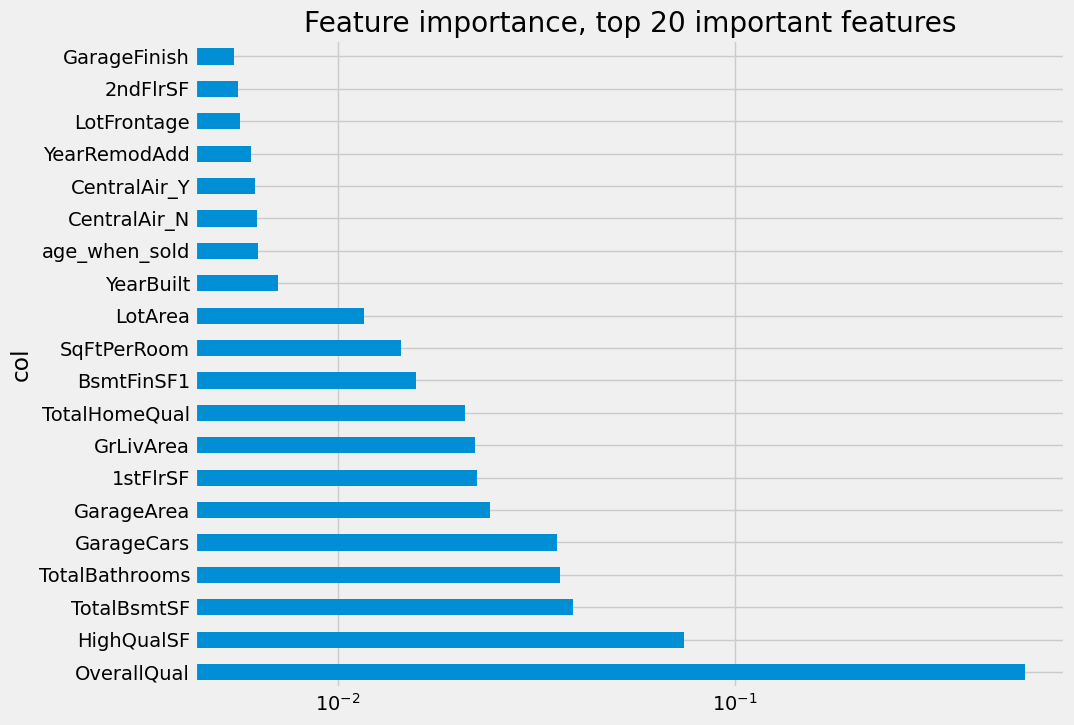

In [133]:
ftr_imp_df.sort_values(by="importance", ascending=False)[:20].plot(kind="barh", x="col", y="importance", figsize=(10, 8), log=True, legend=False)
plt.title("Feature importance, top 20 important features")
plt.show()

Let's consider top 50 features for model building and see the performance difference

In [134]:

top_n = 50
imp_cols = np.unique(
    ftr_imp_df.sort_values(by="importance", ascending=False)[:top_n].col.apply(
        lambda x: x.split("_")[0]
    )
)

imp_cols = [col for col in imp_cols if col in useful_cols]
print(f"no of selected important cols: {len(imp_cols)}")

ordinal_cols_imp = list(set(ordinal_cols).intersection(imp_cols))
cat_cols_imp = list(set(cat_cols).intersection(imp_cols))
year_cols_imp = list(set(year_cols).intersection(imp_cols))
num_cols_imp = list(set(num_cols).intersection(imp_cols))

assert len(imp_cols) == len(ordinal_cols_imp + cat_cols_imp + year_cols_imp + num_cols_imp)



no of selected important cols: 46


In [135]:
fold_scores = []
for fold in range(N_SPLITS):
    xtrain = train_df.loc[train_df.fold != fold, imp_cols]
    xtest = train_df.loc[train_df.fold == fold, imp_cols]
    ytrain = train_df.loc[train_df.fold != fold, "log_SalePrice"]
    ytest = train_df.loc[train_df.fold == fold, "SalePrice"]

    preprocess_pipeline = get_preprocessing_pipe(ordinal_cols=ordinal_cols_imp,
                                                 cat_cols=cat_cols_imp,
                                                 year_cols=year_cols_imp,
                                                 num_cols=num_cols_imp)

    xtrain = preprocess_pipeline.fit_transform(xtrain)
    xtest = preprocess_pipeline.transform(xtest)

    model = RandomForestRegressor(n_estimators=500, random_state=13)
    model.fit(xtrain, ytrain)
    ypreds = model.predict(xtest)
    ypreds = [np.expm1(i) for i in ypreds]
    fold_rmse = mean_squared_log_error(ytest, ypreds, squared=False)
    fold_scores.append(fold_rmse)
    print(f"fold: {fold+1}; rmse: {fold_rmse:.4f}")

print(f"\nAverage fold score: {np.mean(fold_scores):.4f}")


fold: 1; rmse: 0.1558
fold: 2; rmse: 0.1624
fold: 3; rmse: 0.1170
fold: 4; rmse: 0.1314
fold: 5; rmse: 0.1348
fold: 6; rmse: 0.1321
fold: 7; rmse: 0.1409

Average fold score: 0.1392


In [136]:
useful_cols_imp = [col for col in useful_cols if col in imp_cols]

xtrain = preprocess_pipeline.fit_transform(train_df[useful_cols_imp])
xtest = preprocess_pipeline.transform(test_df[useful_cols_imp])

print(xtrain.shape, xtest.shape)

model = RandomForestRegressor(n_estimators=500, random_state=13)
model.fit(xtrain, train_df.log_SalePrice)

preds = model.predict(xtest)
preds = [np.expm1(x) for x in preds]

sample_subm_df["SalePrice"] = preds
sample_subm_df.to_csv(result_path / "subm1_with_imp_ftrs.csv", index=False)

(1460, 65) (1459, 65)


**Score: 0.14303** after this sumission at the public leaderboard. Small improvement of 0.03 from previous model with **less number of features (top 50)**<br>
As we are not seeing any performance impact with selecting subset of features, I think we are good to go with hyperparameter tuning with above features.

## Hyperparameter tuning

In [84]:
best_params = json.load(open(result_path / "rfr_best_params.json", "r"))
best_params

{'n_estimators': 728,
 'criterion': 'squared_error',
 'min_samples_split': 4,
 'max_depth': 11,
 'max_features': 'log2',
 'bootstrap': False}

# Final model with best parameters

In [88]:
xtrain = preprocess_pipeline.fit_transform(train_df[useful_cols_imp])
xtest = preprocess_pipeline.transform(test_df[useful_cols_imp])

model = RandomForestRegressor(**best_params, random_state=13)

model.fit(xtrain, train_df.log_SalePrice)
preds = model.predict(xtest)

preds = [np.expm1(_) for _ in preds]

sample_subm_df["SalePrice"] = preds
sample_subm_df.to_csv(result_path / "rfr_best_params.csv", index=False)

In [36]:
# model = load(result_path / "rfr_best_params.z")
# dump(model, result_path / "rfr_best_params.z")

## Blending preds for built model

In [97]:
from utils import *

rfr_blend = Blending("rfr", train_df[useful_cols_imp+["fold"]+["SalePrice"]], test_df[useful_cols_imp], "SalePrice", preprocess_pipeline, fold_col="fold")
rfr_blend

In [98]:
rfr_blend.optimize(direction="minimize", n_trials=2)

[I 2022-09-22 00:52:09,346] A new study created in memory with name: no-name-02c17e03-2984-4090-8739-c9e0078d30f2
[I 2022-09-22 00:53:12,802] Trial 0 finished with value: 0.1437808315453937 and parameters: {'n_estimators': 433, 'criterion': 'absolute_error', 'min_samples_split': 5, 'max_depth': 9, 'max_features': 'log2', 'boostrap': False}. Best is trial 0 with value: 0.1437808315453937.
[I 2022-09-22 00:53:16,894] Trial 1 finished with value: 0.15732939230767268 and parameters: {'n_estimators': 547, 'criterion': 'squared_error', 'min_samples_split': 4, 'max_depth': 6, 'max_features': 'log2', 'boostrap': False}. Best is trial 0 with value: 0.1437808315453937.
